In [1]:
from ultralytics.models.sam import SAM3SemanticPredictor
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [2]:
new_img = cv2.imread("img/new_img.png")
new_depth = cv2.imread("img/new_depth_raw.tiff", cv2.IMREAD_UNCHANGED)

In [3]:

# Initialize predictor with configuration
overrides = dict(
    conf=0.5,
    task="segment",
    mode="predict",
    model="sam3.pt",
    half=True,  # Use FP16 for faster inference
    save=False,
)
predictor = SAM3SemanticPredictor(overrides=overrides)

# Set image once for multiple queries
predictor.set_image(new_img)

# Query with a single concept
results = predictor(text=["paper cup"])


Ultralytics 8.3.249 🚀 Python-3.10.19 torch-2.9.1+cu128 CUDA:0 (NVIDIA RTX A4000, 14958MiB)
WARNING ⚠️ imgsz=[640] must be multiple of max stride 14, updating to [644]

0: 644x644 2 paper cups, 132.1ms
Speed: 1.3ms preprocess, 132.1ms inference, 2.8ms postprocess per image at shape (1, 3, 644, 644)


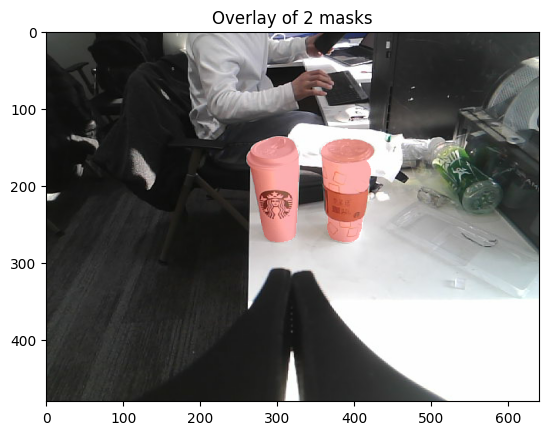

In [4]:
# Get original image
image = results[0].orig_img.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
overlay = image.copy()
alpha = 0.3  # Transparency for each mask

# Get all masks
masks = results[0].masks.data.cpu().numpy()  # (N, H, W)

# Overlay each mask with semi-transparent red
for mask in masks:
    mask_bool = mask == 1  # 或 mask.astype(bool)，根据你的模型输出调整

    # Blend red color into mask region
    overlay[mask_bool] = (
        np.array([255, 0, 0]) * alpha + 
        overlay[mask_bool] * (1 - alpha)
    ).astype(np.uint8)

# Display final image with all masks
plt.imshow(overlay)
plt.title(f"Overlay of {len(masks)} masks")
plt.show()


tensor([0.6562, 0.7002], device='cuda:0', dtype=torch.float16)


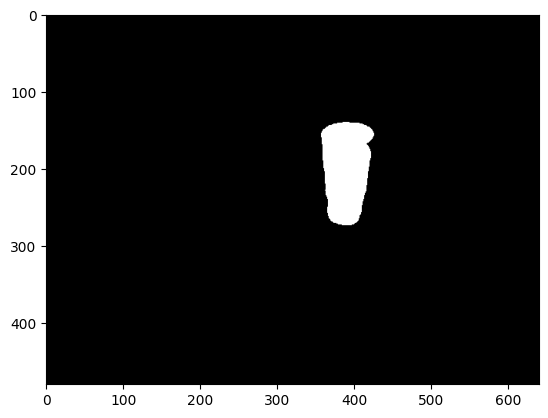

In [40]:
# get highest conf mask
print(results[0].boxes.conf)
max_conf_index = torch.argmin(results[0].boxes.conf).item()
best_mask = results[0].masks.data.cpu().numpy()[max_conf_index]
# show best mask
plt.imshow(best_mask, cmap='gray')

In [41]:

# 创建掩码（只保留袋子区域）
mask = (best_mask * 255).astype(np.uint8)
# 提取深度值（只取有效深度）
depth_values = new_depth[mask == 255]
depth_values = depth_values[depth_values > 0]  # 去除无效深度（0）
if len(depth_values) == 0:
    print("❌ 无有效深度")
else:
    max_depth = np.max(depth_values)
    min_depth = np.min(depth_values)
    median_depth = np.median(depth_values)
    print(f"✅ 袋子深度统计（单位 mm）：最大={max_depth}, 最小={min_depth}, 中值={median_depth}")


✅ 袋子深度统计（单位 mm）：最大=680, 最小=557, 中值=609.0


In [42]:
# 获取轮廓内所有像素坐标
points_2d = np.where(mask == 255)  # (y, x)
ys, xs = points_2d[0], points_2d[1]

# 获取对应深度
depths = new_depth[ys, xs].astype(np.float32)
valid = depths > 0
xs, ys, depths = xs[valid], ys[valid], depths[valid]

# 反投影到3D
fx, fy = 490.2380676269531, 490.2380676269531
cx, cy = 316.89483642578125, 209.28350830078125

zs = depths / 1000.0  # mm → m
xs_3d = (xs - cx) * zs / fx
ys_3d = (ys - cy) * zs / fy

# 点云：Nx3
points_3d = np.stack([xs_3d, ys_3d, zs], axis=-1)  # (N, 3)

In [43]:
import plotly.graph_objects as go
import numpy as np

# 假设 points_3d 是一个 NumPy 数组，形状为 (N, 3)
# 如果还不是 numpy 数组，先转换：
# points_3d = np.asarray(points_3d)
img_color = image[ys, xs].reshape(-1, 3)
# 创建 3D 散点图 从RGB图片取色
fig = go.Figure(data=go.Scatter3d(
    x=points_3d[:, 0],
    y=points_3d[:, 1],
    z=points_3d[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color=img_color,  # 使用原图颜色
        opacity=0.8
    )
))

# 设置窗口标题（在 Plotly 中是 layout.title）
fig.update_layout(
    title="Bag Point Cloud",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'  # 保持真实比例
    ),
    width=800,
    height=600
)

# 显示（Jupyter 中自动嵌入；脚本中会打开浏览器）
fig.show()

In [44]:
import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R_scipy

# bag_pcd: 你的正面点云
bag_pcd = o3d.geometry.PointCloud()
bag_pcd.points = o3d.utility.Vector3dVector(points_3d)
 


In [60]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go
from scipy.optimize import least_squares
from sklearn.decomposition import PCA

# ---------- 1. 拟合 2D 圆 ----------
def fit_circle_2d(points_2d):
    def residuals(params, x, y):
        cx, cy, r = params
        return np.sqrt((x - cx)**2 + (y - cy)**2) - r
    x, y = points_2d[:, 0], points_2d[:, 1]
    cx0, cy0 = np.mean(x), np.mean(y)
    r0 = np.mean(np.sqrt((x - cx0)**2 + (y - cy0)**2))
    result = least_squares(residuals, x0=[cx0, cy0, r0], args=(x, y))
    return result.x  # [cx, cy, r]

# ---------- 2. 使用 sklearn.PCA 拟合 ----------
def fit_cup_circle_with_sklearn_pca(pcd, thickness=0.01):
    """
    使用 sklearn.PCA 计算主方向，在中位数截面拟合圆
    """
    points = np.asarray(pcd.points)
    if points.shape[0] < 20:
        raise ValueError("点云点数不足")

    # 1. 使用 sklearn.PCA
    pca = PCA(n_components=3)
    pca.fit(points)  # 自动减去均值

    # 主成分：pca.components_[0] 是最大方差方向，[2] 是最小方差方向
    # 圆柱对称轴 = 最小方差方向（点沿此方向分布最集中）
    axis_dir = pca.components_[0]  # shape (3,)
    axis_dir = axis_dir / np.linalg.norm(axis_dir)

    # PCA 的 mean_ 是点云质心
    centroid_all = pca.mean_

    # 2. 沿轴投影，找中位数截面
    proj_vals = np.dot(points - centroid_all, axis_dir)
    median_proj = np.median(proj_vals)
    median_point_on_axis = centroid_all + median_proj * axis_dir

    # 3. 提取截面点
    dist_to_plane = np.abs(proj_vals - median_proj)
    mask = dist_to_plane < thickness
    section_points = points[mask]
    if section_points.shape[0] < 10:
        # 自适应：取最近的 10% 点
        dist_sorted = np.sort(dist_to_plane)
        adaptive_thickness = dist_sorted[max(10, len(dist_sorted) // 10)]
        mask = dist_to_plane < adaptive_thickness
        section_points = points[mask]
    if section_points.shape[0] < 10:
        raise ValueError("截面点太少，无法拟合圆")

    # 4. 构建局部正交基 (u, v) ⊥ axis_dir
    if abs(axis_dir[0]) < 0.9:
        temp = np.array([1.0, 0.0, 0.0])
    else:
        temp = np.array([0.0, 1.0, 0.0])
    u = np.cross(axis_dir, temp)
    u /= np.linalg.norm(u)
    v = np.cross(axis_dir, u)

    # 5. 投影到 (u, v) 平面
    vecs = section_points - median_point_on_axis
    proj_u = np.dot(vecs, u)
    proj_v = np.dot(vecs, v)
    points_2d = np.stack([proj_u, proj_v], axis=1)

    # 6. 拟合 2D 圆
    cx, cy, r = fit_circle_2d(points_2d)

    # 7. 3D 圆心
    center_3d = median_point_on_axis + cx * u + cy * v

    # 8. 生成 3D 圆（用于可视化）
    theta = np.linspace(0, 2 * np.pi, 100)
    circle_3d = (
        center_3d[np.newaxis, :] +
        r * (np.cos(theta)[:, np.newaxis] * u[np.newaxis, :] +
             np.sin(theta)[:, np.newaxis] * v[np.newaxis, :])
    )

    return center_3d, r, circle_3d, section_points, axis_dir

# ---------- 3. 可视化 ----------
def visualize_result(pcd, center, circle_3d, section_points, ind, axis_dir):
    points_all = np.asarray(pcd.points)
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=points_all[:, 0], y=points_all[:, 1], z=points_all[:, 2],
        mode='markers', marker=dict(size=1, color=img_color[ind], opacity=0.8),
        name='点云',
        
    ))
    fig.add_trace(go.Scatter3d(
        x=section_points[:, 0], y=section_points[:, 1], z=section_points[:, 2],
        mode='markers', marker=dict(size=3, color='red'),
        name='截面点'
    ))
    fig.add_trace(go.Scatter3d(
        x=circle_3d[:, 0], y=circle_3d[:, 1], z=circle_3d[:, 2],
        mode='lines', line=dict(color='green', width=6),
        name='拟合圆'
    ))
    fig.add_trace(go.Scatter3d(
        x=[center[0]], y=[center[1]], z=[center[2]],
        mode='markers', marker=dict(size=10, color='black'),
        name='中心'
    ))
    # 轴
    fig.add_trace(go.Scatter3d(
        x=[center[0], center[0] - axis_dir[0] * 0.1],
        y=[center[1], center[1] - axis_dir[1] * 0.1],
        z=[center[2], center[2] - axis_dir[2] * 0.1],
        mode='lines', line=dict(color='blue', width=4),
        name='轴向'
    ))

    fig.update_layout(
        title="PCA + 截面圆拟合（使用 sklearn.PCA）",
        scene=dict(aspectmode='data'),
        width=800, height=600
    )
    fig.show()

# ---------- 4. 使用 ----------
# 去噪用 RANSAC 拟合平面（正面）
plane_model, inliers = bag_pcd.segment_plane(
    distance_threshold=0.02,  # 10mm，适合硬纸箱
    ransac_n=5,
    num_iterations=10000
)

# 提取内点（正面点）
front_pcd = bag_pcd.select_by_index(inliers)


# 拟合
center, radius, circle_3d, sec_pts, axis_dir = fit_cup_circle_with_sklearn_pca(
    front_pcd, thickness=0.005
)

print("杯子中心:", center)
print("半径:", f"{radius:.3f} m")

# 可视化
visualize_result(front_pcd, center, circle_3d, sec_pts, inliers, axis_dir)

杯子中心: [   0.094572   -0.018049     0.62828]
半径: 0.043 m


In [12]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# 假设 front_points 是 Nx3 的平面点云
points = front_points

# 1. 原点：平面中心（用包围盒中心更稳定）
min_b = np.min(points, axis=0)
max_b = np.max(points, axis=0)
origin = (min_b + max_b) / 2

# 2. X 轴 = 平面法向量（来自 RANSAC）
z_axis = normal  # 你已有的 normal 向量
z_axis = z_axis / np.linalg.norm(z_axis)

# 3. 在平面上提取长边和短边（用 PCA）
points_centered = points - origin
proj = points_centered - np.outer(np.dot(points_centered, z_axis), z_axis)
pca = PCA(n_components=2)
pca.fit(proj)

long_dir = pca.components_[0]   # 长边
short_dir = pca.components_[1]  # 短边

# 4. 分配轴（按你的要求）
y_axis = long_dir               # Z = 长边（红色）
x_axis = short_dir              # Y = 短边（绿色）

# 5. 构建右手坐标系
y_axis = y_axis / np.linalg.norm(y_axis)
x_axis = x_axis / np.linalg.norm(x_axis)

cross_yz = np.cross(y_axis, z_axis)
if np.dot(x_axis, cross_yz) < 0:
    y_axis = -y_axis



# 6. 固定轴长度为 10 cm (0.1 米)
AXIS_LENGTH = 0.1  # 10 cm

# 7. 绘图
fig = go.Figure()

# 点云（半透明）
fig.add_trace(go.Scatter3d(
    x=points[:, 0], y=points[:, 1], z=points[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color=inl_color,  # 使用原图颜色
        opacity=0.5        # 半透明
    ),
    name='Plane'
))

fig.add_trace(go.Scatter3d(
    x=[origin[0], origin[0] + y_axis[0] * AXIS_LENGTH],
    y=[origin[1], origin[1] + y_axis[1] * AXIS_LENGTH],
    z=[origin[2], origin[2] + y_axis[2] * AXIS_LENGTH],
    mode='lines',
    line=dict(color='green', width=6),
    name='Y'
))


fig.add_trace(go.Scatter3d(
    x=[origin[0], origin[0] + z_axis[0] * AXIS_LENGTH],
    y=[origin[1], origin[1] + z_axis[1] * AXIS_LENGTH],
    z=[origin[2], origin[2] + z_axis[2] * AXIS_LENGTH],
    mode='lines',
    line=dict(color='red', width=6),
    name='Z'
))

fig.add_trace(go.Scatter3d(
    x=[origin[0], origin[0] + x_axis[0] * AXIS_LENGTH], 
    y=[origin[1], origin[1] + x_axis[1] * AXIS_LENGTH], 
    z=[origin[2], origin[2] + x_axis[2] * AXIS_LENGTH],
    mode='lines',
    line=dict(color='blue', width=6),
    name='X'
))

# 布局（保持自动范围，但确保比例一致）
fig.update_layout(
    title="Custom Coordinate Frame",
    scene=dict(
        xaxis_title='X ',
        yaxis_title='Y ',
        zaxis_title='Z ',
        aspectmode='data'  # 保持真实比例
    )
)


# 保存或显示
fig.show()

In [13]:
proj_long = proj @ long_dir    # 所有点在长边方向的投影坐标
proj_short = proj @ short_dir  # 所有点在短边方向的投影坐标

# 长度 = 投影的最大值 - 最小值
length_long = np.max(proj_long) - np.min(proj_long)
length_short = np.max(proj_short) - np.min(proj_short)

print(f"长边长度: {length_long:.3f} m ({length_long*100:.1f} cm)")
print(f"短边长度: {length_short:.3f} m ({length_short*100:.1f} cm)")

长边长度: 0.250 m (25.0 cm)
短边长度: 0.162 m (16.2 cm)


In [14]:
# 可视化抓取点 6 dof
# 抓取点在平面中点延长边的负方向平移指定距离处
center_point = origin - y_axis * (length_long / 2 + length_long / 3)  # 抓取点位置
# 抓取点四元数方向
# 绕自己的z轴转180度
gx_axis = x_axis
gy_axis = y_axis
gz_axis = z_axis

rotation_matrix = np.column_stack((gx_axis, gy_axis, gz_axis))
# 再绕旋转后的x轴转90度
rotation_matrix_90 = R_scipy.from_euler('z', 90, degrees=True).as_matrix()
rotation_matrix = rotation_matrix @ rotation_matrix_90
gx_axis, gy_axis, gz_axis = rotation_matrix[:,0], rotation_matrix[:,1], rotation_matrix[:,2]
r = R_scipy.from_matrix(rotation_matrix)
quaternion = r.as_quat()  # (x, y, z, w)
print("抓取点位置 (m):", center_point)
print("抓取点四元数 (x, y, z, w):", quaternion)
# 可视化抓取点 6 dof

# 抓取点位置
fig.add_trace(go.Scatter3d(
    x=[center_point[0]],
    y=[center_point[1]],
    z=[center_point[2]],
    mode='markers',
    marker=dict(color='orange', size=8),
    name='Grasp Point'
))
# 抓取点方向（坐标轴）
GRASP_AXIS_LENGTH = 0.025  # 5 cm
fig.add_trace(go.Scatter3d(
    x=[center_point[0], center_point[0] + gx_axis[0] * GRASP_AXIS_LENGTH],
    y=[center_point[1], center_point[1] + gx_axis[1] * GRASP_AXIS_LENGTH],
    z=[center_point[2], center_point[2] + gx_axis[2] * GRASP_AXIS_LENGTH],
    mode='lines',
    line=dict(color='blue', width=6),
    name='Grasp X'
))
fig.add_trace(go.Scatter3d(
    x=[center_point[0], center_point[0] + gy_axis[0] * GRASP_AXIS_LENGTH],
    y=[center_point[1], center_point[1] + gy_axis[1] * GRASP_AXIS_LENGTH],
    z=[center_point[2], center_point[2] + gy_axis[2] * GRASP_AXIS_LENGTH],
    mode='lines',
    line=dict(color='green', width=6),
    name='Grasp Y'
))
fig.add_trace(go.Scatter3d(
    x=[center_point[0], center_point[0] + gz_axis[0] * GRASP_AXIS_LENGTH],
    y=[center_point[1], center_point[1] + gz_axis[1] * GRASP_AXIS_LENGTH],
    z=[center_point[2], center_point[2] + gz_axis[2] * GRASP_AXIS_LENGTH],
    mode='lines',
    line=dict(color='red', width=6),
    name='Grasp Z'
))


抓取点位置 (m): [ -0.0013658    -0.19385     0.44866]
抓取点四元数 (x, y, z, w): [    0.19306    -0.21622     0.67104     0.68241]
